In [155]:
import os
import time
import requests
import bs4 as bs
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
import tensorflow as tf
from matplotlib import style
import yahoo_finance as yahoo
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ohlc
from IPython.display import display, Math, Latex
style.use('ggplot')

In [2]:
getter = yahoo.Share('^IXCO')

In [3]:
ixco = getter.get_historical('2000-1-1', '2016-12-31');

In [6]:
ixco_date = np.array([ixco[i]['Date'] for i in range(len(ixco))])
ixco_date = np.flip(ixco_date, axis=0)

In [7]:
ixco_close = np.array([ixco[i]['Close'] for i in range(len(ixco))])
ixco_close = np.flip(ixco_close, axis=0)
ixco_close = ixco_close.astype(float)

In [28]:
pd.to_datetime(ixco_date)

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', length=4277, freq=None)

In [136]:
ibm = pd.read_csv('./ibm/ibm.csv')
ibm['Date'] = pd.to_datetime(ibm['Date'])
ibm.set_index('Date', inplace=True)
ibm = ibm.loc['2000-01-01':'2016-12-31']
ibm.set_index(pd.to_datetime(ixco_date), inplace=True)
ibm['IXCO'] = pd.Series(ixco_close, index=ibm.index)
ibm.head()

,Open,High,Low,Close,Volume,Adj Close,IXCO
2000-01-03,112.4375,116.0000,111.875,116.0000,10347700,87.761136,2368.820068
2000-01-04,114.0000,114.5000,110.875,112.0625,8227800,84.782175,2234.530029
2000-01-05,112.9375,119.7500,112.125,116.0000,12733200,87.761136,2220.600098
2000-01-06,118.0000,118.9375,113.500,114.0000,7971900,86.248013,2113.300049
2000-01-07,117.2500,117.9375,110.625,113.5000,11856700,85.869732,2204.379883


In [137]:
year = {
    2000: ibm.loc['2000-01-01':'2000-12-31'].index,
    2001: ibm.loc['2001-01-01':'2001-12-31'].index,
    2002: ibm.loc['2002-01-01':'2002-12-31'].index,
    2003: ibm.loc['2003-01-01':'2003-12-31'].index,
    2004: ibm.loc['2004-01-01':'2004-12-31'].index,
    2005: ibm.loc['2005-01-01':'2005-12-31'].index,
    2006: ibm.loc['2006-01-01':'2006-12-31'].index,
    2007: ibm.loc['2007-01-01':'2007-12-31'].index,
    2008: ibm.loc['2008-01-01':'2008-12-31'].index,
    2009: ibm.loc['2009-01-01':'2009-12-31'].index,
    2010: ibm.loc['2010-01-01':'2010-12-31'].index,
    2011: ibm.loc['2011-01-01':'2011-12-31'].index,
    2012: ibm.loc['2012-01-01':'2012-12-31'].index,
    2013: ibm.loc['2013-01-01':'2013-12-31'].index,
    2014: ibm.loc['2014-01-01':'2014-12-31'].index,
    2015: ibm.loc['2015-01-01':'2015-12-31'].index,
    2016: ibm.loc['2016-01-01':'2016-12-31'].index,
}

In [35]:
for y in range(2000,2017):
    plt.clf()
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
    ax1.plot(year[y], (ibm['Close'][year[y]] - ibm['Close'][year[y]].mean())/ibm['Close'][year[y]].std(), linewidth=0.5, label="IBM")
    ax1.plot(year[y], (ibm['IXCO'][year[y]] - ibm['IXCO'][year[y]].mean())/ibm['IXCO'][year[y]].std(), linewidth=0.5, label="IXCO")
    ax2.bar(year[y], ibm['Volume'][year[y]])
    ax1.legend(loc='upper right', frameon=False)
    ax1.xaxis.set_visible(False)
    plt.savefig("./ibm/ixco_ibm_year_{}.png".format(y), dpi=1000)

In [80]:
ibm_ohlc = ibm['Adj Close'].resample('7D').ohlc()
ibm_ohlc = ibm_ohlc.reset_index()
ibm_ohlc['index'] = ibm_ohlc['index'].map(mdates.date2num)
ibm_volume = ibm['Volume'].resample('7D').sum()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
candlestick_ohlc(ax1, ibm_ohlc.values, width=2, colorup='g')
ax2.fill_between(ibm_volume.index.map(mdates.date2num), ibm_volume.values, 0)
ax1.xaxis_date()
ax1.xaxis.set_visible(False)
plt.savefig("./ibm/candle_stick.png", dpi=1000)

In [138]:
temporal_window = 3
ma7 = 7
ma30 = 30
ibm_x = ibm.drop(['High', 'Close', 'Volume', 'Adj Close', 'Low'], axis=1)
ibm_x.head()


,Open,IXCO
2000-01-03,112.4375,2368.820068
2000-01-04,114.0000,2234.530029
2000-01-05,112.9375,2220.600098
2000-01-06,118.0000,2113.300049
2000-01-07,117.2500,2204.379883


In [139]:
ibm['ma7'] = ibm['Close'].rolling(ma7).mean()
ibm['ma30'] = ibm['Close'].rolling(ma30).mean()
ibm_x.head()

,Open,IXCO
2000-01-03,112.4375,2368.820068
2000-01-04,114.0000,2234.530029
2000-01-05,112.9375,2220.600098
2000-01-06,118.0000,2113.300049
2000-01-07,117.2500,2204.379883


In [140]:
ibm_x['w1'] = ibm['Close'].iloc[temporal_window:]
ibm_x['w2'] = ibm['Close'].iloc[temporal_window:]
ibm_x['w3'] = ibm['Close'].iloc[temporal_window:]
ibm_x['ma7_1'] = ibm['ma7'].iloc[temporal_window:]
ibm_x['ma7_2'] = ibm['ma7'].iloc[temporal_window+ma7:]
ibm_x['ma7_3'] = ibm['ma7'].iloc[temporal_window+2*ma7:]
ibm_x['ma7_4'] = ibm['ma7'].iloc[temporal_window+4*ma7:]
ibm_x['ma30_1'] = ibm['ma30'].iloc[temporal_window:]
ibm_x['ma30_2'] = ibm['ma30'].iloc[temporal_window+ma30:]
ibm_x['ma30_3'] = ibm['ma30'].iloc[temporal_window+2*ma30:]
ibm_x['ma30_4'] = ibm['ma30'].iloc[temporal_window+4*ma30:]
ibm_x['std30'] = ibm['Close'].rolling(ma30).std()

In [141]:
ibm_x.dropna(axis=0, how='any', inplace=True)
ibm_y = ibm['Close'].loc[ibm_x.index]

In [142]:
ibm_y.head()

2000-06-28    113.781197
2000-06-29    114.000000
2000-06-30    109.562500
2000-07-03    109.500000
2000-07-05    105.000000
Name: Close, dtype: float64

In [143]:
ibm_x.head()

,Open,IXCO,w1,w2,w3,ma7_1,ma7_2,ma7_3,ma7_4,ma30_1,ma30_2,ma30_3,ma30_4,std30
2000-06-28,110.0000,2313.340088,113.781197,113.781197,113.781197,113.214271,113.214271,113.214271,113.214271,112.528120,112.528120,112.528120,112.528120,4.864287
2000-06-29,111.7500,2280.320068,114.000000,114.000000,114.000000,112.874985,112.874985,112.874985,112.874985,112.732286,112.732286,112.732286,112.732286,4.790226
2000-06-30,112.6875,2343.969971,109.562500,109.562500,109.562500,112.169628,112.169628,112.169628,112.169628,112.848953,112.848953,112.848953,112.848953,4.663116
2000-07-03,108.7500,2351.389893,109.500000,109.500000,109.500000,111.839271,111.839271,111.839271,111.839271,112.951036,112.951036,112.951036,112.951036,4.550070
2000-07-05,105.6250,2256.429932,105.000000,105.000000,105.000000,110.857128,110.857128,110.857128,110.857128,112.809370,112.809370,112.809370,112.809370,4.731808


In [167]:
ibm_y_train.shape

(3146,)

In [257]:
ibm_x_train, ibm_y_train = ibm_x['2000-01-01':'2012-12-31'].as_matrix(), ibm_y['2000-01-01':'2012-12-31'].as_matrix()[:,np.newaxis]
ibm_x_test, ibm_y_test = ibm_x['2013-01-01':'2016-12-31'].as_matrix(), ibm_y['2013-01-01':'2016-12-31'].as_matrix()[:, np.newaxis]
ibm_x_train = (ibm_x_train - ibm_x_train.min())/(ibm_x_train.max()- ibm_x_train.min())
ibm_y_train = (ibm_y_train - ibm_y_train.min())/(ibm_y_train.max()- ibm_y_train.min())
ibm_x_test = (ibm_x_test - ibm_x_test.min())/(ibm_x_test.max()- ibm_x_test.min())
ibm_y_test = (ibm_y_test - ibm_y_test.min())/(ibm_y_test.max()- ibm_y_test.min())

In [260]:
N_FEATURES = ibm_x_train.shape[1]
X = tf.placeholder(tf.float32, [None, N_FEATURES])
Y = tf.placeholder(tf.float32, [None, 1])
N_HIDDEN_L1 = 50


In [266]:
w_1 = tf.Variable(tf.truncated_normal([N_FEATURES, N_HIDDEN_L1], stddev=0.1))
b_1 = tf.Variable(tf.constant(value=1, dtype=tf.float32, shape = [N_HIDDEN_L1]))
h_1 = tf.nn.tanh(tf.matmul(X, w_1) + b_1)
print (h_1)

Tensor("Tanh_3:0", shape=(?, 50), dtype=float32)


In [267]:
w_2 = tf.Variable(tf.truncated_normal([N_HIDDEN_L1, 1], stddev=0.1))
b_2 = tf.Variable(tf.constant(value=1, dtype=tf.float32, shape = [1]))
pred = (tf.matmul(h_1, w_2) + b_2)
print (pred)

Tensor("add_29:0", shape=(?, 1), dtype=float32)


In [268]:
LEARNING_RATE = 1e-2
cost = tf.reduce_mean(tf.square(pred-Y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

Training.......
------ Elapsed time ------- Epoch ---- Cost 
---Running time: 0.06341314315795898 seconds ---
**************************************************


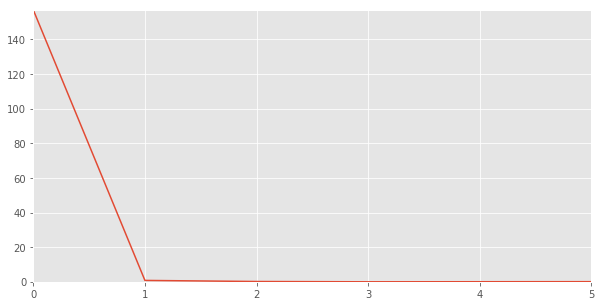

In [269]:
BATCH_SIZE = 20
N_EPOCHS = 5
batch_size = BATCH_SIZE
n_epoches = N_EPOCHS
n_samples = ibm_x_train.shape[0]
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    n_iterations = np.int(np.floor(n_samples/batch_size))+1
    start_time = time.time()
    cost_history = np.empty(shape=[1],dtype=float)
    print ("Training.......")
    print ("------ Elapsed time ------- Epoch ---- Cost ")
#     for epoch in np.arange(n_epoches+1):
    for itr in np.arange(n_iterations):
        start = (itr * batch_size) % (n_samples - batch_size)
        batch_x, batch_y = ibm_x_train[start:start+batch_size], ibm_y_train[start:start+batch_size]
        feed_dict_train = {X: batch_x, Y: batch_y}
        _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)
#         if(epoch % 1 == 0):
#             print ("------ {:12.7f} ------- {:5d} ---- {:12.10f} ".format((time.time() - start_time), epoch, c))
        cost_history = np.append(cost_history,c)
    print ("---Running time: %s seconds ---" % (time.time() - start_time))
    print ('*'*50)
    fig = plt.figure(figsize=(10,5))
    plt.plot(cost_history)
    plt.axis([0,epoch,0,np.max(cost_history)])
    plt.show()
            

Making prediction.......


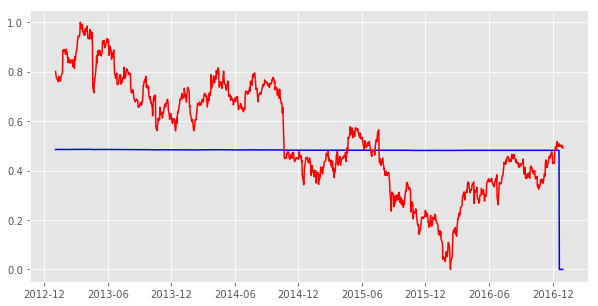

In [270]:

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print ("Making prediction.......")
    start_time = time.time()
    n_samples = ibm_x_test.shape[0]
    prediction = np.zeros((n_samples, 1))
    n_iterations = np.int(np.floor(n_samples/batch_size))+1
    for itr in np.arange(n_iterations):
        start = (itr * batch_size) % (n_samples - batch_size)
        batch_x, batch_y = ibm_x_test[start:start + batch_size], ibm_y_test[start:start + batch_size]
        feed_dict_test = {X: batch_x, Y: batch_y}
        prediction[start:start + batch_size] = session.run(pred, feed_dict=feed_dict_test)
    fig = plt.figure(figsize=(10,5))
    plt.plot(ibm_x['2013-01-01':'2016-12-31'].index, prediction, color='b')
    plt.plot(ibm_x['2013-01-01':'2016-12-31'].index, ibm_y_test, color='r')
    plt.show()


In [271]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(prediction, ibm_y_test))

In [272]:
rms

0.2297952721551223

In [228]:
prediction

array([[ 0.7861765 ],
       [ 0.78615463],
       [ 0.78613126],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])